# Find 3 Disks
Given an image with a background texture, and three overlaid texured disks, predict the centerpoint of the labeled “most concpicuous disk.”

(**Note:** on February 16, 2022 I saved a version of this to `graveyard/Find_3_Disks_before_generators.ipynb`)

In [7]:
import gc
import PIL
import math
import time
import random
import numpy as np
from os import listdir
from os.path import join

import os.path

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
%tensorflow_version 2.x
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

# Import DiskFind utilities for PredatorEye.
import sys
sys.path.append('/content/drive/My Drive/PredatorEye/shared_code/')
import DiskFind as df

# df.set_global_random_seed(20220108)
df.set_global_random_seed(20220220)
model_save_directory = '/content/drive/My Drive/PredatorEye/saved_models/'

TensorFlow version: 2.8.0


# Define uniform texture dataset

In [8]:
# def MakeUniformTextureDataset(dataset_size, image_size, image_depth):
def make_uniform_dataset(dataset_size, image_size, image_depth):
    dataset_shape = (dataset_size, image_size, image_size, image_depth)
    images = []
    labels = []
    for i in tqdm(range(dataset_size)):
        # (image, label) = generateUniformExample(image_size, image_depth)
        (image, label) = generate_uniform_example(image_size, image_depth)
        images.append(image)
        labels.append(label)
        # # TODO TEMP -- Draw image for debugging
        # if ((i % 50) == 0) and (i < (50 * 5)): df.draw_image(image)
    return (images, labels)

# blah blah
# return an image (pixel tensor) and a label as (x, y) tensor
# def generateUniformExample(image_size, image_depth):
def generate_uniform_example(image_size, image_depth):
    bg_color = np.random.random_sample(image_depth)
    fg_color = np.random.random_sample(image_depth)
    disk_radius = image_size * df.relative_disk_radius()
    image_shape = (image_size, image_size, image_depth)
    image = np.full(image_shape, bg_color, dtype=np.float32)

    # Find 3 non-overlapping disk positions inside image.
    def random_center():
        s = image_size - (2 * disk_radius)
        return (np.random.random_sample(2) * s) + disk_radius
    centers = [random_center()]
    min_dist = 3 * disk_radius
    while len(centers) < 3:
        c = random_center()
        all_ok = True
        for o in centers:
            if (df.dist2d(c, o) < min_dist):
                all_ok = False
        if (all_ok):
            centers.append(c)

    # Draw soft-eged disk with given centerpoint and color.
    def draw_disk(center, color):
        cx = int(center[0])
        cy = int(center[1])
        dr = int(disk_radius)
        for x in range(cx - dr, cx + dr + 1):
            for y in range(cy - dr, cy + dr + 1):
                d = math.sqrt(math.pow(x - cx, 2) + math.pow(y - cy, 2))
                if (d <= dr):
                    blend = df.spot_utility((x, y), center, dr * 0.85, dr)
                    image[x, y, :] = df.interpolate(blend, bg_color, color) 

    # Draw 3 soft-edged disks, with colors progressively more like background.
    draw_disk(centers[0], fg_color)
    draw_disk(centers[1], df.interpolate(0.33, fg_color, bg_color))
    draw_disk(centers[2], df.interpolate(0.66, fg_color, bg_color))

    # return image
    # print('centers[0] =', centers[0])
    # print('type(centers[0]) =', type(centers[0]))
    label = centers[0] / image_size

    # TODO When I visualized the labels, they appeared xy flipped
    #      trying "unflipping them"
    label = np.array((label[1], label[0]))

    return (image, label)

# Reader for complex dataset

In [9]:
# Define complex texture (photo plus synthetic) dataset

# 20220130 this structure (copied from above) is wrong.
# We want to read the dir in the main function.
# the "per filename" function could later be expanded to do amplification
# if so, should return lists, which would need to be concatenated in caller.

# # temp for prototyping
# directory_pathname = '/content/drive/My Drive/PredatorEye/f3d_training_set/'

# # "Amplify" dataset by adding one modified version of each precomputed image
# amplify_2x = True

# def make_complex_dataset():
def make_complex_dataset(directory_pathname =
                         '/content/drive/My Drive/PredatorEye/f3d_training_set/',
                         amplify_2x = True):

    directory_contents = listdir(directory_pathname)

    ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ##
    # size_limit = 50
    # print('Limit complex dataset size to', size_limit)
    # directory_contents = directory_contents[0:size_limit]
    ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ##

    images = []
    labels = []
    for filename in tqdm(directory_contents):
        image_pathname = os.path.join(directory_pathname, filename)
        (image, label) = make_complex_example(image_pathname)
        images.append(image)
        labels.append(label)
        if amplify_2x:
            (image, label) = modify_complex_example(image, label)
            images.append(image)
            labels.append(label)
    return (images, labels)

# Read image file at given pathname, pre-process for use in training model.
def make_complex_example(image_pathname):
    # Read image file.
    pixels = df.read_image_file_as_pixel_tensor(image_pathname)
    # Check for expected format.
    assert df.check_pixel_tensor(pixels), 'wrong file format: ' + image_pathname    
    # Parse disk center position from file name.
    filename = os.path.basename(image_pathname)
    center_position = df.fcd_normalized_xy(filename, pixels)
    return (pixels, center_position)

# Make modified copy of one traing example (as a pixel tensor and xy label).
# (Specifically: invert brighness, mirror horizontally, rotate 1/4, 1/2, or 3/4)
def modify_complex_example(image, label):

    def center_rot90(cp): return (cp[1], 0.5 - (cp[0] - 0.5))
    def center_flip(cp): return (0.5 - (cp[0] - 0.5), cp[1])

    # invert brighness of image:
    image = 1 - image

    # mirror horizontally
    scaled_pixels = np.flip(image, axis=1)
    label = center_flip(label)

    # Rotate one of: 1/4, 1/2, or 3/4
    n = random.randrange(1, 4)
    for i in range(n):
        # image = np.rot90(image, k=1, axes=(0, 1))
        image = np.rot90(image, k=1, axes=(1, 0))
        label = center_rot90(label)
    # label = np.array(label)

    # counter-sensible experiment -- 11:38 20220202
    label = center_flip(label)

    image = image.astype(np.float32)
    return (image, label)

# # make_complex_example()
# (i, p) = make_complex_dataset()
# print('len(i) =', len(i))
# print('i[0].dtype =', i[0].dtype)
# print('i[0].shape =', i[0].shape)
# print('type(i) =', type(i))
# print('p[0] =', p[0])

def center_rot90(cp): return (cp[1], 0.5 - (cp[0] - 0.5))
def center_flip(cp): return (0.5 - (cp[0] - 0.5), cp[1])


print('center_flip((0.2, 0.1)) =', center_flip((0.2, 0.1)))
print('center_flip([0.2, 0.1]) =', center_flip([0.2, 0.1]))
print()
print('center_rot90((0.2, 0.1)) =', center_rot90((0.2, 0.1)))
print('center_rot90([0.2, 0.1]) =', center_rot90([0.2, 0.1]))
print()

print('center_rot90((0.8, 0.4)) =', center_rot90((0.8, 0.4)))
print('center_rot90((0.4, 0.2)) =', center_rot90((0.4, 0.2)))
print('center_rot90((0.2, 0.6)) =', center_rot90((0.2, 0.6)))
print('center_rot90((0.6, 0.8)) =', center_rot90((0.6, 0.8)))

np.array((1,2))

center_flip((0.2, 0.1)) = (0.8, 0.1)
center_flip([0.2, 0.1]) = (0.8, 0.1)

center_rot90((0.2, 0.1)) = (0.1, 0.8)
center_rot90([0.2, 0.1]) = (0.1, 0.8)

center_rot90((0.8, 0.4)) = (0.4, 0.19999999999999996)
center_rot90((0.4, 0.2)) = (0.2, 0.6)
center_rot90((0.2, 0.6)) = (0.6, 0.8)
center_rot90((0.6, 0.8)) = (0.8, 0.4)


array([1, 2])

# New experiment with generators. 
has exit at end of this 

  0%|          | 0/20000 [00:00<?, ?it/s]

len(train_images) = 16000
len(test_images) = 4000
train_images[0].shape = (128, 128, 3)
len(test_labels) = 4000
Epoch 1/100
250/250 [==============================] - 31s 120ms/step - loss: 0.1101 - accuracy: 0.4999 - in_disk: 0.0614 - val_loss: 0.0487 - val_accuracy: 0.4857 - val_in_disk: 0.0550
Epoch 2/100
250/250 [==============================] - 29s 116ms/step - loss: 0.0433 - accuracy: 0.4955 - in_disk: 0.0613 - val_loss: 0.0525 - val_accuracy: 0.4848 - val_in_disk: 0.0580
Epoch 3/100
250/250 [==============================] - 29s 116ms/step - loss: 0.0424 - accuracy: 0.4963 - in_disk: 0.0640 - val_loss: 0.0441 - val_accuracy: 0.5142 - val_in_disk: 0.0593
Epoch 4/100
250/250 [==============================] - 29s 116ms/step - loss: 0.0419 - accuracy: 0.4997 - in_disk: 0.0619 - val_loss: 0.0429 - val_accuracy: 0.5148 - val_in_disk: 0.0600
Epoch 5/100
250/250 [==============================] - 29s 116ms/step - loss: 0.0415 - accuracy: 0.5017 - in_disk: 0.0622 - val_loss: 0.0420 - v

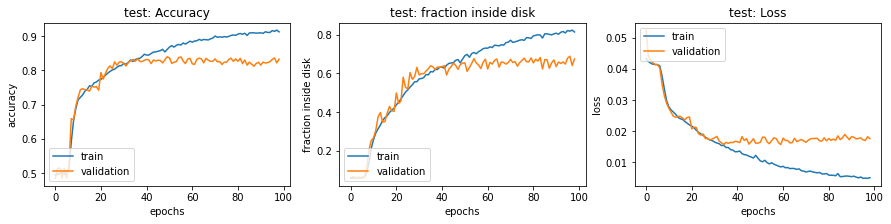

AssertionError: ignored

In [10]:
# ...

# a little nugget of code from
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# which may suggest how I can do "real-time data augmentation"
#
# Maybe I can read the base dataset with 20,000 images, hold them in memory,
# then make a Generator (or something that just behaves like it) each batch I
# "flow" from it will get randomly augumented.
#
# I assume the call to model.fit(x_batch, y_batch) defaults to a single batch
# (epoch=1) do I need to do my own logging etc?
#
# Note that I am currently using batch_size=128 (of 128x128x3 images).

# def dummy():
#     # here's a more "manual" example
#     for e in range(epochs):
#         print('Epoch', e)
#         batches = 0
#         for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=32):
#             model.fit(x_batch, y_batch)
#             batches += 1
#             if batches >= len(x_train) / 32:
#                 # we need to break the loop by hand because
#                 # the generator loops indefinitely
#                 break

# # Should be able to just call: make_complex_dataset(amplify_2x=False)
# # to get the non-augmented base dataset of 20,000 images
# # Then lets split that (80%/20%?) holding out a dataset for evaluation

# def runtime_augmentation_test(model, epochs, batch_size):
#     # Read base dataset, return list of images and labels.
#     base_images, base_labels = make_complex_dataset(amplify_2x=False)
#     # Split both 80% / 20%.
#     train_fraction = 0.8
#     train_count = int(len(base_images) * train_fraction)
#     train_images = base_images[: train_count]
#     test_images = base_images[train_count : ]
#     print('len(train_images) =', len(train_images))
#     print('len(test_images) =', len(test_images))
#     print('train_images[0].shape =', train_images[0].shape)
#     train_labels = base_labels[: train_count]
#     test_labels = base_labels[train_count : ]
#     print('len(test_labels) =', len(test_labels))

#     train_images = np.array(train_images, dtype=np.float32)
#     train_labels = np.array(train_labels, dtype=np.float32)
#     test_images = np.array(test_images, dtype=np.float32)
#     test_labels = np.array(test_labels, dtype=np.float32)

#     very_temp_train_util(train_images, train_labels, model, epochs, batch_size)

# def very_temp_train_util(x_train, y_train, model, epochs, batch_size):
#     # here's a more "manual" example
#     for e in range(epochs):
#         print('Epoch', e)
#         # batches = 0
#         # batch counter
#         b = 0
#         # for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=32):
#         # for x_batch, y_batch in (x_train[b * batch_size: (b + 1) * batch_size],
#         #                          y_train[b * batch_size: (b + 1) * batch_size]):
#         while True:
#             x_batch = x_train[b * batch_size: (b + 1) * batch_size]
#             y_batch = y_train[b * batch_size: (b + 1) * batch_size]
#             model.fit(x_batch, y_batch)
#             # batches += 1
#             # if batches >= len(x_train) / 32:
#             b += 1
#             if b >= len(x_train) / batch_size:
#                 # we need to break the loop by hand because
#                 # the generator loops indefinitely
#                 break

# # debug tests:
# epochs = 10
# batch_size = 128
# model = df.make_disk_finder_model(np.zeros((1, 128, 128, 3)))
# runtime_augmentation_test(model, epochs, batch_size)


# TODO 20220219 -- build a real generator based on tf.keras.utils.Sequence
#
# Initially do something like the "complex dataset": 20,000 read from disk and
#     20,000 more through doing one augmentation per image.
#
# see example code:
#     API doc: tf.keras.utils.Sequence
#         https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
#     Write your own Custom Data Generator for TensorFlow Keras
#         https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3

# class CIFAR10Sequence(Sequence):
# class Find3DisksGenerator(Sequence):
class Find3DisksGenerator(tf.keras.utils.Sequence):
    
    # Construct generator given arrays of base images and labels, and batch size
    # def __init__(self, x_set, y_set, batch_size):
        # self.x, self.y = x_set, y_set
    def __init__(self, base_images, base_labels, batch_size):
        self.base_images = base_images
        self.base_labels = base_labels
        self.batch_size = batch_size

    # TODO 20220219 for now assume generator is twice the size of base data.
    def __len__(self):
        # return math.ceil(len(self.x) / self.batch_size)
        return math.ceil(2 * len(self.base_images) / self.batch_size)

    # # TODO 20220219 for now assume generator is twice the size of base data.
    # # TODO note this is surely not the most efficient/pythonic way to do this.
    # # def __getitem__(self, idx):
    # def __getitem__(self, index):

    #     # print()
    #     # print('index = ', index)
    #     # print('len(self) = ', len(self))
    #     # print('self.batch_size = ', self.batch_size)
    #     # print('len(self.base_images) = ', len(self.base_images))

    #     # batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
    #     # batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

    #     # Take the next "half batch" chunk from base arrays.
    #     # hbs = self.batch_size / 2
    #     # print('hbs = ', hbs)
    #     hbs = int(self.batch_size / 2)
    #     # batch_images = self.base_images[idx * self.batch_size : (idx + 1) * hbs]
    #     # batch_labels = self.base_labels[idx * self.batch_size : (idx + 1) * hbs]
    #     # start = index * self.batch_size
    #     start = index * hbs
    #     end = (index + 1) * hbs
    #     # print('start = ', start)
    #     # print('end = ', end)

    #     batch_images = self.base_images[start : end]
    #     batch_labels = self.base_labels[start : end]

    #     # print('half batch:')
    #     # print('batch_images.shape = ', batch_images.shape)
    #     # print('batch_labels.shape = ', batch_labels.shape)

    #     # Glue two copies of each array together, doubling the size.
    #     batch_images = np.concatenate((batch_images, batch_images), axis=0)
    #     batch_labels = np.concatenate((batch_labels, batch_labels), axis=0)

    #     # print('full batch:')
    #     # print('batch_images.shape = ', batch_images.shape)
    #     # print('batch_labels.shape = ', batch_labels.shape)

    #     # Now for the first "hbs" of each, make a modified augmentation.
    #     for i in range(hbs):
    #         image = batch_images[i]
    #         label = batch_labels[i]
    #         image, label = modify_complex_example(image, label)
    #         batch_images[i] = image
    #         batch_labels[i] = label

    #     # print('modified batch:')
    #     # print('batch_images.shape = ', batch_images.shape)
    #     # print('batch_labels.shape = ', batch_labels.shape)

    #     # TODO 20220219 later come back and learn what this means:
    #     # return np.array([
    #     #     resize(imread(file_name), (200, 200))
    #     #        for file_name in batch_x]), np.array(batch_y)

    #     return np.array(batch_images), np.array(batch_labels)

    # TODO 20220219 for now assume generator is twice the size of base data.
    # TODO note this is surely not the most efficient/pythonic way to do this.
    # def __getitem__(self, idx):
    def __getitem__(self, index):
        # Take the next "half batch" chunk from base arrays.
        hbs = int(self.batch_size / 2)
        start = index * hbs
        end = (index + 1) * hbs
        batch_images = self.base_images[start : end]
        batch_labels = self.base_labels[start : end]
        # Glue two copies of each array together, doubling the size.
        batch_images = np.concatenate((batch_images, batch_images), axis=0)
        batch_labels = np.concatenate((batch_labels, batch_labels), axis=0)
        # Now for the first "hbs" of each, make a modified augmentation.
        for i in range(hbs):
            image = batch_images[i]
            label = batch_labels[i]
            image, label = modify_complex_example(image, label)
            batch_images[i] = image
            batch_labels[i] = label
        
        # # TODO 20220220
        # df.visualize_dataset(batch_images, batch_labels)

        return np.array(batch_images), np.array(batch_labels)

# 20220219 note that the pathname from which data is read is not passed in here.
#          It is buried down inside make_complex_dataset(). Should it be an arg?

def f3d_read_and_split_base_dataset():
    # Read base dataset, return list of images and labels.
    base_images, base_labels = make_complex_dataset(amplify_2x=False)
    # Split both 80% / 20%.
    train_fraction = 0.8
    train_count = int(len(base_images) * train_fraction)
    train_images = base_images[: train_count]
    test_images = base_images[train_count : ]
    print('len(train_images) =', len(train_images))
    print('len(test_images) =', len(test_images))
    print('train_images[0].shape =', train_images[0].shape)
    train_labels = base_labels[: train_count]
    test_labels = base_labels[train_count : ]
    print('len(test_labels) =', len(test_labels))

    train_images = np.array(train_images, dtype=np.float32)
    train_labels = np.array(train_labels, dtype=np.float32)
    test_images = np.array(test_images, dtype=np.float32)
    test_labels = np.array(test_labels, dtype=np.float32)

    # very_temp_train_util(train_images, train_labels, model, epochs, batch_size)
    return train_images, train_labels, test_images, test_labels


# 20220219 copied from DiskFind.py
# def f3d_train_augmented_model(model, X_train, y_train, X_test, y_test,
#                               epochs, batch_size, plot_title):
def f3d_train_augmented_model(model, epochs, batch_size, plot_title):
    
    (train_images, train_labels, test_images, test_labels) = f3d_read_and_split_base_dataset()

    training_data_generator = Find3DisksGenerator(train_images, train_labels, batch_size)

    # history = model.fit(X_train,
    #                     y_train,
    #                     validation_data = (X_test, y_test),
    history = model.fit(training_data_generator,
                        validation_data = (test_images, test_labels),
                        epochs=epochs,
                        batch_size=batch_size)
    print()
    # plot_accuracy_and_loss(history, plot_title)
    df.plot_accuracy_and_loss(history, plot_title)
    return history

# debug tests:
epochs = 100
batch_size = 128
model = df.make_disk_finder_model(np.zeros((1, 128, 128, 3)))
# runtime_augmentation_test(model, epochs, batch_size)
f3d_train_augmented_model(model, epochs, batch_size, 'test')

# TODO 20220217 stop here rather than proceed on with rest of notebook.
assert False

# Generate dataset

In [ ]:
df.reset_random_seeds()
start_time = time.time()

# (dataset_images,
#  dataset_labels) = make_uniform_dataset(dataset_size = 5000,
#                                         image_size = 128,
#                                         image_depth = 3) # RGB

(dataset_images, dataset_labels) = make_complex_dataset()

elapsed_seconds = int(time.time() - start_time)
print('Elapsed time: ' + str(elapsed_seconds) + ' seconds (' +
      str(int(elapsed_seconds / 60)) +' minutes).')

# Split dataset

In [ ]:
print('Total dataset size =', len(dataset_images))

(images_train, images_test,
 labels_train, labels_test) = train_test_split(dataset_images,
                                               dataset_labels,
                                               test_size=0.2)
 
# 20220202 oops, I was keeping these around, think I ought to free them.
dataset_images = []
dataset_labels = []

# Convert from Python lists to np arrays.
images_train = np.array(images_train, dtype=np.float32)
labels_train = np.array(labels_train, dtype=np.float32)
images_test = np.array(images_test, dtype=np.float32)
labels_test = np.array(labels_test, dtype=np.float32)


print('images_train.shape[0] =', images_train.shape[0])
print('labels_train.shape[0] =', labels_train.shape[0])
print('images_test.shape[0] =', images_test.shape[0])
print('labels_test.shape[0] =', labels_test.shape[0])

# Visualize some labels

In [ ]:
df.reset_random_seeds()
df.visualize_dataset(images = images_test, labels=labels_test)

# Build and train model

In [ ]:
# Run a model.
df.reset_random_seeds()
start_time = time.time()
fcd_model_timestamp = df.timestamp_string()
(model, history) = ([], [])  # To release memory when rerunning in notebook.
gc.collect()

model = df.make_disk_finder_model(images_train)
history = df.run_model(model,
                       images_train, labels_train, images_test, labels_test,
                       epochs=100,
                       batch_size= 128,
                       plot_title='F3D')

elapsed_seconds = int(time.time() - start_time)
print('Elapsed time: ' + str(elapsed_seconds) + ' seconds (' +
      str(int(elapsed_seconds / 60)) +' minutes).')

# model.save(model_save_directory + fcd_model_timestamp)
model_save_path = (model_save_directory +
                   fcd_model_timestamp +
                   '_Find_3_Disks_complex')
model.save(model_save_path)
print('Saved trained model to', model_save_path)

In [ ]:
print(type(history))
print(type(history.history['loss']))
print(len(history.history['loss']))
print(history.history['loss'])

# Visualize some predictions

In [ ]:
df.reset_random_seeds()
# df.visualize_dataset(images=images_test, labels=labels_test, model=model)
df.visualize_dataset(images=images_test, labels=labels_test, model=model, count=20)